In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from arch import arch_model
from pmdarima import auto_arima
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.stattools import kpss, adfuller
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy import stats
from scipy.stats import probplot, shapiro
from statsmodels.stats.diagnostic import het_arch
import statsmodels.api as sm
from arch import arch_model
import math 
from matplotlib import rc
import matplotlib.pyplot as mpl
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [2]:
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
mpl.rcParams['font.size'] = 10

In [4]:
plt.rcParams["legend.loc"] = "upper left"

In [5]:
df = pd.read_excel('C:/JupyterLab/AI_prediction/data/raw/EU_ml_models.xlsx')

In [6]:
df

,year,ml_models
0,2003,2
1,2004,0
2,2005,2
3,2006,6
4,2007,3
5,2008,2
6,2009,1
7,2010,4
8,2011,2
9,2012,2


([<matplotlib.axis.XTick at 0x2823af6d2b0>,
 [Text(0, 0, '0'),
  Text(3, 0, '3'),
  Text(6, 0, '6'),
  Text(9, 0, '9'),
  Text(12, 0, '12'),
  Text(15, 0, '15'),
  Text(18, 0, '18')])

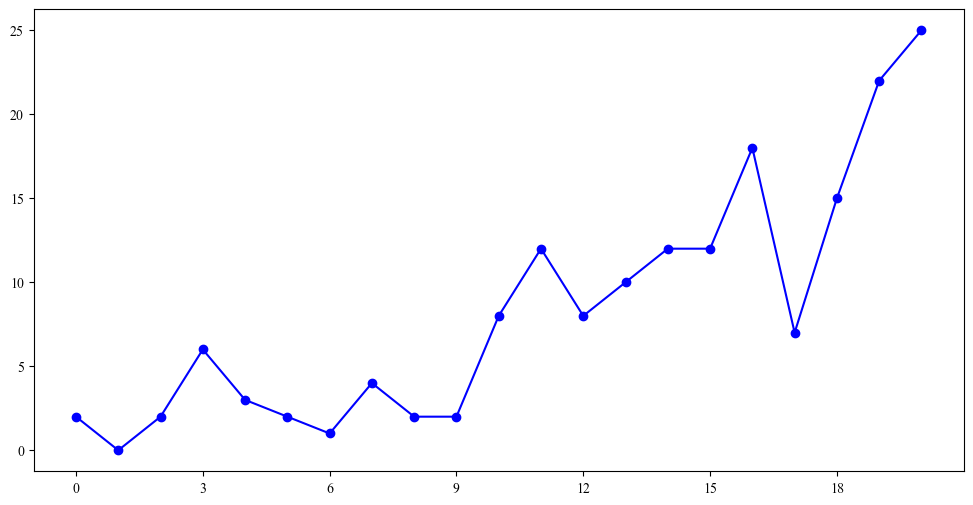

In [7]:
xticks_labels = df.index.tolist()
xticks_filtered = [year for year in xticks_labels if year % 3 == 0]

plt.figure(figsize=(12, 6))
plt.plot(df['ml_models'], marker='o', color='blue', label='ml_models')
plt.xticks(xticks_filtered)

As in other regions, the number of models fluctuated significantly during the period under review. There is an upward trend in the data, but its polynomial was determined by comparing two models estimated using the classical least squares method.

### Trend type verification

In [8]:
y = df["ml_models"]
t = df["year"]

X_lin = sm.add_constant(t)
model_lin = sm.OLS(y, X_lin).fit()

X_quad = sm.add_constant(np.column_stack((t, t**2)))
model_quad = sm.OLS(y, X_quad).fit()

# Linear model statistics
p_value_lin = model_lin.pvalues.iloc[1] 
r2_lin = model_lin.rsquared
se_lin = np.sqrt(model_lin.mse_resid)
f_lin = model_lin.fvalue
f_crit_lin = stats.f.ppf(0.95, model_lin.df_model, model_lin.df_resid)

# Quadratic model statistics
p_value_quad = model_quad.pvalues.iloc[1]
r2_quad = model_quad.rsquared
se_quad = np.sqrt(model_quad.mse_resid)
f_quad = model_quad.fvalue
f_crit_quad = stats.f.ppf(0.95, model_quad.df_model, model_quad.df_resid)

# Degrees of freedom 
n = len(df)
k_lin = X_lin.shape[1] 
k_quad = X_quad.shape[1] 

df1_new = n - k_lin - 1
df2_new = n - k_quad - 1

F_user_updated = (se_lin / se_quad) ** 2
F_crit_updated = stats.f.ppf(0.95, df1_new, df2_new)

pd.options.display.float_format = '{:.8f}'.format

results_updated = pd.DataFrame({
    "Statistic": [
        "p-value (t-test for trend coefficient)",
        "R-squared",
        "Standard error of residuals",
        "F-statistic (user definition)",
        "Critical F (alpha=0.05, user definition)"
    ],
    "Linear trend model": [
        p_value_lin, r2_lin, se_lin, F_user_updated, F_crit_updated
    ],
    "Quadratic trend model": [
        p_value_quad, r2_quad, se_quad, F_user_updated, F_crit_updated
    ]
})

results_updated

,Statistic,Linear trend model,Quadratic trend model
0,p-value (t-test for trend coefficient),0.00000061,0.01154555
1,R-squared,0.73848076,0.81873837
2,Standard error of residuals,3.75391646,3.21089619
3,F-statistic (user definition),1.36683685,1.36683685
4,"Critical F (alpha=0.05, user definition)",2.25667097,2.25667097


Based on the coefficient of determination, it was determined that the model with a quadratic trend fitted the data better than the model with a linear trend. The Akaike information criterion was also slightly lower. The obtained p values ​​indicate that the parameters for both the linear and quadratic trend are significant in the models. However, Fisher's exact test did not reveal a significant difference between the models; the critical value was significantly higher than the squared standard error of the residuals. Further calculations assumed that a quadratic trend did not occur in the data.

### Stationarity testing

In [9]:
kpss(df["ml_models"], nlags=4, regression="ct")
df["time"] = df["year"]
df["timesq"] = df["year"]**2
X_trend = sm.add_constant(df[["time", "timesq"]])
model_trend = sm.OLS(df["ml_models"], X_trend).fit()
residuals_trend = model_trend.resid
kpss(residuals_trend, regression="c", nlags=4)

C:\Users\tester\AppData\Local\Temp\ipykernel_13888\1192270414.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(residuals_trend, regression="c", nlags=4)


(np.float64(0.08740819076207253),
 np.float64(0.1),
 4,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [10]:
def check_stationarity(series):
    # Source https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [11]:
check_stationarity(df['ml_models'])

ADF Statistic: -0.499064
p-value: 0.892199
Critical Values:
	1%: -3.809
	5%: -3.022
	10%: -2.651
Non-stationary


In [12]:
adf_result_original = adfuller(df['ml_models'])

In [13]:
time_series_diff = np.diff(df["ml_models"])

df_diff = pd.DataFrame({"Differenced": time_series_diff})

In [14]:
def check_stationarity(series):
    # Source https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [15]:
check_stationarity(df_diff['Differenced'])

ADF Statistic: -8.840131
p-value: 0.000000
Critical Values:
	1%: -4.223
	5%: -3.189
	10%: -2.730
Stationary


In [16]:
adf_result_diff = adfuller(df_diff['Differenced'])

Series integrated in the first degree

### Autocorelation functions

In [17]:
time_series_diff = np.diff(df["ml_models"])

df_diff = pd.DataFrame({"Differenced": time_series_diff})

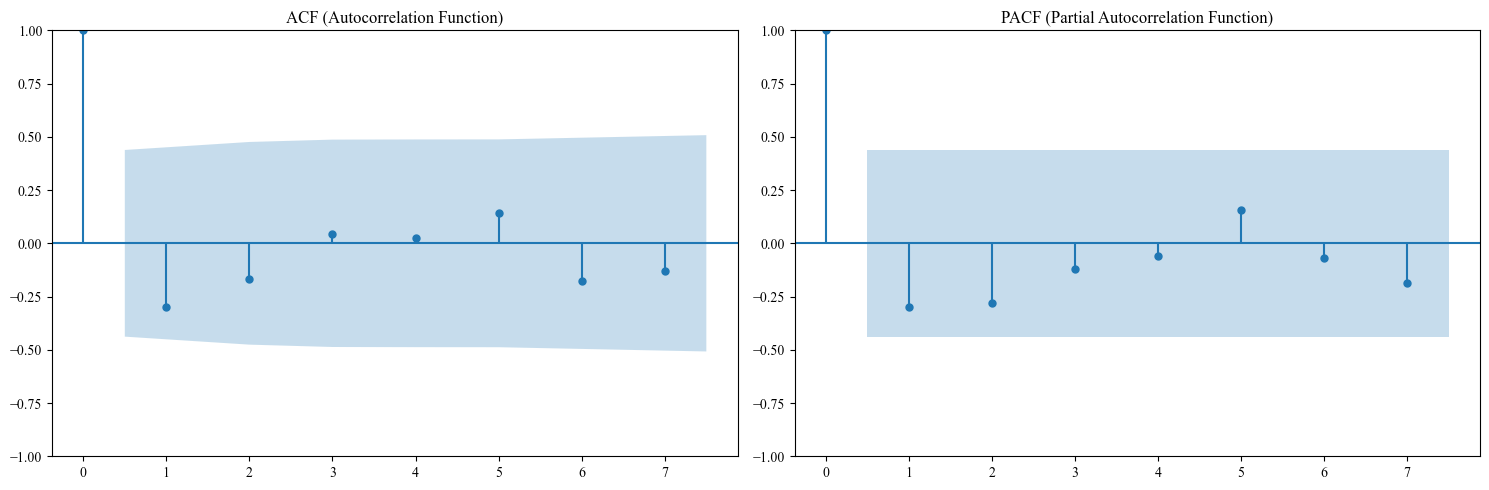

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sm.graphics.tsa.plot_acf(df_diff["Differenced"], lags=7, alpha=0.05, ax=axes[0], title="ACF (Autocorrelation Function)")

sm.graphics.tsa.plot_pacf(df_diff["Differenced"], lags=7, alpha=0.05, ax=axes[1], title="PACF (Partial Autocorrelation Function)")

plt.tight_layout()
plt.show()

The ACF function showed no strong, repeating patterns or slow decay, so differencing brought the series to a stationary form. None of the values for subsequent shifts in the plots fell outside the confidence interval. Therefore, the series most likely lacks AR and MA components.

### ARIMA forecast on testing dataset

#### Chosing best ARIMA model

In [19]:
df2 = df.set_index('year')

In [20]:
train_size = len(df) - 4  
train, test = df['ml_models'][:train_size], df['ml_models'][train_size:]
train_years = df['year'][:train_size]
test_years = df['year'][train_size:]

In [21]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [22]:
stepwise_fit = auto_arima(train, trace=True, start_p=0, d=1, start_q=0, information_criterion='aic', test='adf',
suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=84.562, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=86.102, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=84.994, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=84.247, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.117 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   17
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -41.124
Date:                Thu, 16 Oct 2025   AIC                             84.247
Time:                        14:17:50   BIC                             85.020
Sample:                             0   HQIC                            84.287
                                 - 17                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         9.9999      4.468      2.238      0.025       1.244      18.756
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.50   Prob(JB):                         0.67
Heteroskedasticity (H):               1.76   Skew:                             0.12
Prob(H) (two-sided):                  0.55   Kurtosis:                         1.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
stepwise_fit = auto_arima(train, trace=True, start_p=0, d=1, start_q=0, information_criterion='bic', test='adf',
suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=86.107, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=88.420, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=87.311, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=85.020, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.126 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   17
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -41.124
Date:                Thu, 16 Oct 2025   AIC                             84.247
Time:                        14:17:50   BIC                             85.020
Sample:                             0   HQIC                            84.287
                                 - 17                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         9.9999      4.468      2.238      0.025       1.244      18.756
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.50   Prob(JB):                         0.67
Heteroskedasticity (H):               1.76   Skew:                             0.12
Prob(H) (two-sided):                  0.55   Kurtosis:                         1.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

From the perspective of the value of both criteria, the best model was found to be one without autoregressive (AR) or moving average (MA) components. A model fitting attempt based on the training set confirmed the conclusions drawn from the analysis of the ACF and PACF graphs. Due to the obtained results, further estimation and forecasting using the ARIMA model based on the training set was abandoned. Holt's model was used for this purpose.

### ARIMA forecast on full dataset

#### Choosing best ARIMA model

In [24]:
stepwise_fit = auto_arima(df['ml_models'], trace=True, start_p=0, d=1, start_q=0, information_criterion='aic', test='adf',
suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=119.464, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=119.613, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=117.356, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=118.822, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=119.540, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.277 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -55.678
Date:                Thu, 16 Oct 2025   AIC                            117.356
Time:                        14:17:50   BIC                            120.343
Sample:                             0   HQIC                           117.939
                                 - 21                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0305      0.300      3.438      0.001       0.443       1.618
ma.L1         -0.6706      0.227     -2.951      0.003      -1.116      -0.225
sigma2        14.8807      5.563      2.675      0.007       3.978      25.783
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 0.08
Prob(Q):                              0.66   Prob(JB):                         0.96
Heteroskedasticity (H):               3.68   Skew:                            -0.02
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
stepwise_fit = auto_arima(df['ml_models'], trace=True, start_p=0, d=1, start_q=0, information_criterion='bic', test='adf',
suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=121.455, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=122.600, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=120.343, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=119.817, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.119 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -58.411
Date:                Thu, 16 Oct 2025   AIC                            118.822
Time:                        14:17:50   BIC                            119.817
Sample:                             0   HQIC                           119.016
                                 - 21                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        20.1499      6.283      3.207      0.001       7.835      32.465
===================================================================================
Ljung-Box (L1) (Q):                   2.07   Jarque-Bera (JB):                 2.71
Prob(Q):                              0.15   Prob(JB):                         0.26
Heteroskedasticity (H):               6.43   Skew:                            -0.78
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The lowest AIC value was obtained by the model with the MA component and the intercept. In terms of the BIC criterion, the (0,1,1) model with the intercept was ranked second. Due to the selection of a model with at least one component by the criteria, an attempt was made to use the ARIMA model for the series

### ARIMA(0,1,1) forecast

In [26]:
future_dates = [2024, 2025, 2026, 2027]

In [27]:
sarima=ARIMA(df['ml_models'],order=(0,1,1))
predicted=sarima.fit()

In [28]:
print(predicted.summary())

                               SARIMAX Results                                
Dep. Variable:              ml_models   No. Observations:                   21
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -57.770
Date:                Thu, 16 Oct 2025   AIC                            119.540
Time:                        14:17:50   BIC                            121.531
Sample:                             0   HQIC                           119.929
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2899      0.187     -1.550      0.121      -0.656       0.077
sigma2        18.8164      6.687      2.814      0.005       5.709      31.924
Ljung-Box (L1) (Q):                   0.31   Jarque-

In [29]:
residuals = predicted.resid

In [30]:
forecast_steps = 4
forecast = predicted.get_forecast(steps=forecast_steps)

In [31]:
last_year = df2.index.max()

forecast_index = pd.Index([last_year + i for i in range(1, 5)])

forecast_series = pd.Series(forecast, index=forecast_index)

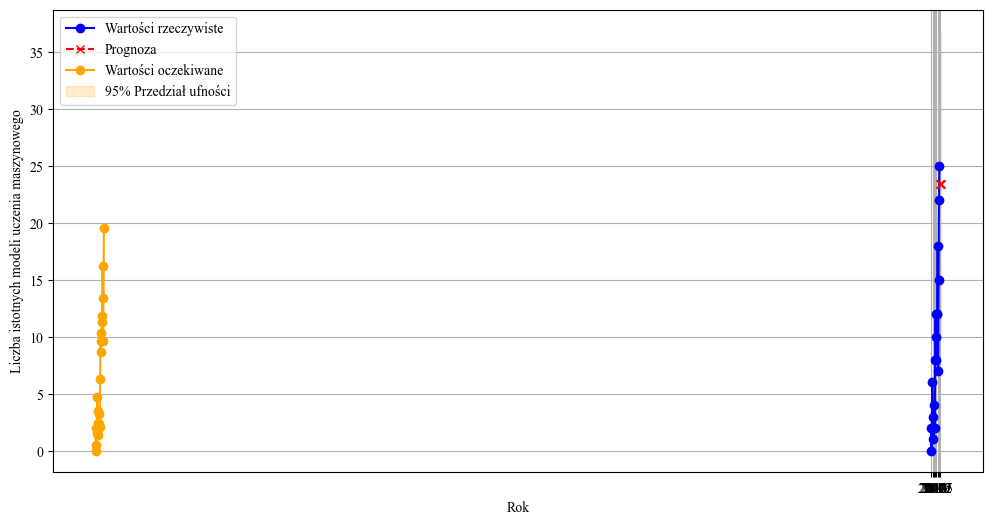

In [32]:
xticks_labels = df2.index.tolist()
xticks_labels.extend(future_dates)
xticks_filtered = [year for year in xticks_labels if year % 3 == 0]

predicted=sarima.fit().predict();predicted

conf_int = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(df2['ml_models'], marker='o', color='blue', label='Wartości rzeczywiste')
plt.plot(forecast_index, forecast.predicted_mean, marker='x', linestyle='--', color='red', label='Prognoza')
plt.plot(predicted, marker='o', color='orange', label='Wartości oczekiwane')
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1],
                 color='orange', alpha=0.2, label='95% Przedział ufności')
plt.xlabel("Rok")
plt.ylabel('Liczba istotnych modeli uczenia maszynowego')
plt.xticks(xticks_filtered)
plt.legend()
plt.grid(True)
plt.show()

The expected values were significantly smoother than the actual data. There was a significant increase in values between 2020 and 2023 that was not captured by the model, so the forecast is very pessimistic.

In [33]:
mse_ar = mean_squared_error(df2['ml_models'], predicted)
rmse_ar = np.sqrt(mse_ar)
mae_ar = mean_absolute_error(df2['ml_models'], predicted)
rsquare_ar = r2_score(df2['ml_models'], predicted)
mape_ar = np.mean(np.abs((df2['ml_models'] - predicted)) / df2['ml_models'])* 100

print(f"Mean Squared Error (MSE): {mse_ar}")
print(f"RMSE: {rmse_ar:.2f}")
print(f"Mean Absolute Error (MAE): {mae_ar}")
print(f'Determination:', rsquare_ar)
print(f"Mean Absolute Percentage Error (MAPE): {mape_ar}")

Mean Squared Error (MSE): 18.12684604205624
RMSE: 4.26
Mean Absolute Error (MAE): 3.420798924215624
Determination: 0.6281888788582883
Mean Absolute Percentage Error (MAPE): nan


In [34]:
shapiro_stat, shapiro_p = shapiro(residuals)
print(f"Test Shapiro–Wilka: statystyka = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

Test Shapiro–Wilka: statystyka = 0.9449, p-value = 0.2716


In [35]:
arch_test = het_arch(residuals)
print(f"ARCH test p-value: {arch_test[1]:.4f}")

ARCH test p-value: 0.3594


Based on the p-values, the null hypotheses of the tests were rejected. The model residuals are normally distributed and do not exhibit variable variance. The model residuals are normally distributed and do not exhibit variable variance.

### Regular and dumped Holt model forecast 

In [36]:
# Regular Holt model
holt_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
holt_forecast = holt_model.forecast(4)

# Dumped Holt model
holt_damped_model = ExponentialSmoothing(train, trend='add', damped_trend=True, seasonal=None).fit()
holt_damped_forecast = holt_damped_model.forecast(4)

NameError: name 'future_years' is not defined

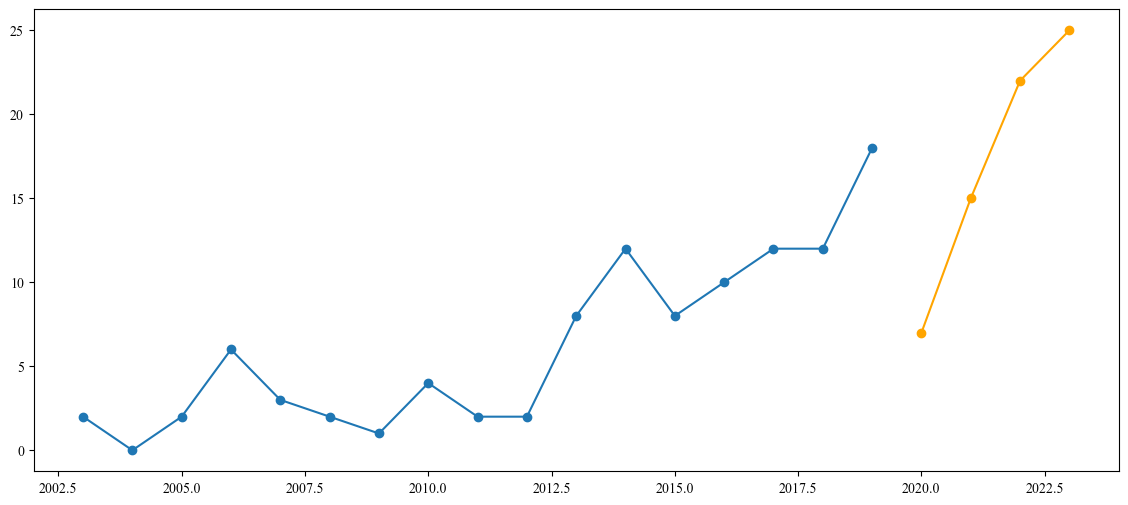

In [37]:
plt.figure(figsize=(14, 6))

plt.plot(train_years, train, label='Zbiór uczący', marker='o')

plt.plot(test_years, test, label='Zbiór testowy', color='orange', marker='o')

plt.plot(future_years, holt_forecast, label='Prognoza na bazie zbioru uczącego modelem Holta', marker='x', linestyle='--', color='red')
plt.plot(future_years, holt_damped_forecast,label='Prognoza na bazie zbioru uczącego modelem Holta z tłumieniem',marker='.', linestyle='--', color='green')
plt.xlabel("Rok")
plt.ylabel("Liczba istotnych modeli uczenia maszynowego")
plt.legend()
plt.xticks(xticks_filtered)
plt.grid(True)
plt.ylim(0, 30)

In [ ]:
mse_u = mean_squared_error(test['ml_models'], holt_forecast)
rmse_u = np.sqrt(mean_squared_error(test['ml_models'], holt_forecast))
mae_u = mean_absolute_error(test['ml_models'], holt_forecast)
mape_u = np.mean(np.abs((test['ml_models'] - holt_forecast) / test['ml_models'])) * 100

# Wyniki
print(f"MSE: {mse_u:.2f}")
print(f"RMSE: {rmse_u:.2f}")
print(f"MAE: {mae_u:.2f}")
print(f"MAPE: {mape_u:.2f}%")

In [ ]:
mse_u = mean_squared_error(test['ml_models'], holt_forecast)
rmse_u = np.sqrt(mean_squared_error(test['ml_models'], holt_forecast))
mae_u = mean_absolute_error(test['ml_models'], holt_forecast)
mape_u = np.mean(np.abs((test['ml_models'] - holt_forecast) / test['ml_models'])) * 100

# Wyniki
print(f"MSE: {mse_u:.2f}")
print(f"RMSE: {rmse_u:.2f}")
print(f"MAE: {mae_u:.2f}")
print(f"MAPE: {mape_u:.2f}%")

In [ ]:
mse_ud = mean_squared_error(test['ml_models'], holt_damped_forecast)
rmse_ud = np.sqrt(mean_squared_error(test['ml_models'], holt_damped_forecast))
mae_ud = mean_absolute_error(test['ml_models'], holt_damped_forecast)
mape_ud = np.mean(np.abs((test['ml_models'] - holt_damped_forecast) / test['ml_models'])) * 100

# Wyniki
print(f"MSE: {mse_ud:.2f}")
print(f"RMSE: {rmse_ud:.2f}")
print(f"MAE: {mae_ud:.2f}")
print(f"MAPE: {mape_ud:.2f}%")

### Model Holta (dumped, zwykły)

In [ ]:
holt_model2 = ExponentialSmoothing(df2['ml_models'], trend='add', seasonal=None).fit()
fitted_holt = holt_model2.fittedvalues
holt_forecast2 = holt_model2.forecast(4)

holt_damped_model2 = ExponentialSmoothing(df2['ml_models'], trend='add', damped_trend=True, seasonal=None).fit()
fitted_holt_damped = holt_damped_model2.fittedvalues
holt_damped_forecast2 = holt_damped_model2.forecast(4)

In [ ]:
fitted_holt_damped

In [ ]:
# Wariancja reszt jako baza błędu standardowego
residuals = df2['ml_models'] - fitted_holt_damped
res_var = np.var(residuals)
se = np.sqrt(res_var)

# Budowa przedziałów (dla 95%)
z = 1.96
ci_upper = holt_damped_forecast2 + z * se
ci_lower = holt_damped_forecast2 - z * se

In [ ]:
# Ostatni rok z danych historycznych
last_year = df2.index.max()

# Tworzymy nowy indeks czasu dla prognozy: 2024–2027
forecast_index = pd.Index([last_year + i for i in range(1, 5)])

# Tworzymy nową serię z poprawnym indeksem
forecast_series = pd.Series(holt_damped_forecast2.values, index=forecast_index)

In [ ]:
residuals

In [ ]:
forecast_steps = 4
z = 1.96
se_steps = [np.sqrt(res_var * h) for h in range(1, forecast_steps + 1)]
lower_bound = holt_damped_forecast2 - z * np.array(se_steps)
upper_bound = holt_damped_forecast2 + z * np.array(se_steps)

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['ml_models'], label='Wartości rzeczywiste', marker='o')
plt.plot(df.index, fitted_holt_damped, label='Wartości oczekiwane modelu Holta', marker='o', color='orange')
plt.plot(df.index, fitted_values_add, label='Wartości oczekiwane modelu Holta z tłumieniem', marker='o', color='green')
plt.plot(pd.date_range(df.index[-1], periods=4, freq='Y')[:], holt_damped_forecast2, label='Prognoza (4 lata) modelem Holta z tłumieniem', color='green', linestyle='--', marker='x')
plt.plot(pd.date_range(df.index[-1], periods=4, freq='Y')[:], holt_forecast2, label='Prognoza (4 lata) modelem Holta ', color='red', linestyle='--', marker='x')
plt.fill_between(pd.date_range(df.index[-1], periods=4, freq='Y')[:], lower_bound, upper_bound, label='95% Przedział ufności', color='orange', alpha=0.2)
plt.xlabel('Rok')
plt.ylabel("Liczba istotnych modeli uczenia maszynowego")
plt.legend()
plt.grid(True)

In [ ]:
mse_hw = mean_squared_error(df2['ml_models'], fitted_values_add)
rmse_hw = np.sqrt(mse_ar)
mae_hw = mean_absolute_error(df2['ml_models'], fitted_values_add)
rsquare_hw = r2_score(df2['ml_models'], fitted_values_add)
mape_hw = np.mean(np.abs((df2['ml_models'] - fitted_values_add)) / df2['ml_models'])* 100

print(f"Mean Squared Error (MSE): {mse_hw}")
print(f"RMSE: {rmse_hw:.2f}")
print(f"Mean Absolute Error (MAE): {mae_hw}")
print(f'Determination:', rsquare_hw)
print(f"Mean Absolute Percentage Error (MAPE): {mape_hw}")

In [ ]:
actual_values = df2['ml_models'].values

In [ ]:
actual_values

In [ ]:
residuals = actual_values - fitted_values_add

In [ ]:
shapiro_stat, shapiro_p = shapiro(residuals)
print(f"Test Shapiro–Wilka: statystyka = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

In [ ]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(residuals)
print(f"ARCH test p-value: {arch_test[1]:.4f}")

In [ ]:
# Histogram reszt
plt.hist(residuals, bins=20, edgecolor="black", density=True)
plt.title("Histogram of Residuals")